In [1]:
# a demonstration of use of the logistic regression classifier 
# for content classification on doc2vec docs vectors
# where logit probabilities of the classified content against the given categories can be used as relevance rating
# towards the classified categories

# references:
# [1] https://deeplearning4j.org/word2vec.html
# [2] http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
# [3] http://scikit-learn.org/stable/modules/cross_validation.html

# author Michal Stefanik  mistefan  at  redhat dot com

import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.estimators.estimator import SKCompat

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

# D2VWrapper is our implementation providing vectorization of the documents based on doc2vec
from doc2vec_wrapper import D2VWrapper

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# optimization steps are reduced on TEST_MODE
TEST_MODE = False

# target categories
product_list = ["amq", "eap", "webserver", "datagrid", "fuse", "brms", "bpmsuite", "devstudio", "cdk",
                "developertoolset", "rhel", "softwarecollections", "mobileplatform", "openshift"]

In [4]:
# initialize d2v_wrapper providing as well metadata about the models state
d2v_wrapper = D2VWrapper(content_categories=product_list,
                         vector_length=500)

# EITHER initialize the vocab of documents and minimize the distances of embeddings in training phase
# d2v_wrapper.init_model_vocab(content_basepath="../../data/content/playground/auto/nostem",
#                              basepath_suffix="_content.csv", drop_short_docs=10)
# d2v_wrapper.train_model(shuffle=True, epochs=1 if TEST_MODE else 20)
# d2v_wrapper.infer_content_vectors()
# d2v_wrapper.persist_trained_wrapper(model_save_path="trained_models/wrapper/10epoch_train_stem_not_removed_header")

# OR load initialized and trained wrapper if available
d2v_wrapper.load_persisted_wrapper("trained_models/wrapper/header_incl/10epoch_train_stem_not_removed_header")

2017-04-26 21:01:37,923 : INFO : Loading serialized wrapper model from: trained_models/wrapper/header_incl/10epoch_train_stem_not_removed_header
2017-04-26 21:01:37,924 : INFO : Loading all_base_vocab_docs objects
2017-04-26 21:01:46,264 : INFO : Initialized 43478 headers of 43478 for vectorization
2017-04-26 21:01:46,265 : INFO : Loading all_base_vocab_docs vectors
2017-04-26 21:02:24,962 : INFO : Loading trained Doc2Vec model
2017-04-26 21:02:24,993 : INFO : loading Doc2Vec object from trained_models/wrapper/header_incl/10epoch_train_stem_not_removed_headerdoc2vec.mod
2017-04-26 21:02:25,183 : INFO : loading docvecs recursively from trained_models/wrapper/header_incl/10epoch_train_stem_not_removed_headerdoc2vec.mod.docvecs.* with mmap=None
2017-04-26 21:02:25,184 : INFO : loading doctag_syn0 from trained_models/wrapper/header_incl/10epoch_train_stem_not_removed_headerdoc2vec.mod.docvecs.doctag_syn0.npy with mmap=None
2017-04-26 21:02:26,913 : INFO : loading syn1neg from trained_model

In [6]:
# transform the doc data set into a vector set of the given vector_length
doc_vectors_labeled = d2v_wrapper.infer_vocab_content_vectors()
# TODO: below func merged to d2v_wrapper, remove for newer model checkpoints
doc_vectors_labeled.columns = np.arange(len(doc_vectors_labeled.columns[:-1])).tolist()+["y"]
doc_vectors = doc_vectors_labeled.iloc[:, :-1]
doc_labels = doc_vectors_labeled.iloc[:, -1]

2017-04-26 21:05:01,828 : INFO : Returning already inferred doc vectors of 43478 all_base_vocab_docs


In [7]:
doc_vectors_labeled.head(10)

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,y
0,-0.261148,-0.143183,0.206254,0.002638,-0.136853,-0.184459,0.400641,-0.026630,0.055222,-0.507141,...,-0.002771,0.193008,-0.061081,0.116081,0.053434,0.050748,0.061903,-0.013674,-0.081310,amq
1,0.129629,0.330915,0.078725,0.343039,-0.164130,-0.322203,0.089643,-0.096555,-0.143530,0.177542,...,-0.036439,0.098115,-0.047751,0.191983,0.103851,-0.014857,0.147300,-0.048710,0.028055,amq
2,-0.122895,0.042616,0.311727,0.068287,-0.190215,-0.286972,-0.030751,-0.023960,-0.217911,0.005918,...,-0.034230,0.203534,0.057952,0.132727,0.011877,-0.031473,0.093483,-0.105260,-0.107189,amq
3,-0.081051,-0.112118,0.157368,0.018006,-0.024450,-0.293881,-0.078382,-0.241100,0.103017,0.140719,...,0.023935,0.223113,-0.047766,0.126704,0.071557,-0.091953,0.223931,-0.076425,0.104130,amq
4,-0.248997,-0.072568,0.270651,0.378066,0.100578,0.104005,0.063351,0.003771,0.149455,0.300134,...,0.020857,0.122567,0.028789,0.043602,-0.046213,-0.016964,0.118787,-0.025481,-0.185460,amq
5,0.132138,-0.070874,0.411625,-0.073018,-0.201902,0.128727,-0.243356,-0.355984,0.040756,-0.311196,...,-0.045529,0.303851,0.028779,0.072786,-0.054523,-0.022502,0.141018,-0.041490,0.015366,amq
6,0.415581,0.094154,0.334570,-0.033714,0.001877,-0.015157,0.087919,-0.355922,0.082679,0.082770,...,-0.023633,0.257899,0.042370,0.109216,0.000828,-0.008879,0.222199,-0.005134,-0.033780,amq
7,0.672777,-0.549360,0.014788,0.015485,-0.034586,-0.177955,-0.117172,-0.534560,-0.230965,-0.185388,...,-0.071189,0.291642,-0.042231,0.106547,-0.054053,-0.031451,0.192578,-0.021674,-0.050568,amq
8,-0.231420,0.146912,0.162502,0.121931,-0.277280,-0.140563,0.052438,-0.346920,0.122520,0.111098,...,0.000184,0.000794,-0.000187,0.000104,-0.000457,-0.000089,-0.000197,-0.000503,0.000012,amq
9,0.087633,0.331549,0.233062,-0.045076,-0.174967,-0.079236,0.206668,-0.217895,-0.059720,-0.198520,...,0.000184,0.000794,-0.000187,0.000104,-0.000457,-0.000089,-0.000197,-0.000503,0.000012,amq


In [8]:
# limit the content to specific categories
# limit_prod_list = ["webserver", "datagrid", "fuse", "brms"]
# doc_vectors = doc_vectors[doc_labels.isin(limit_prod_list)]
# doc_labels = doc_labels[doc_labels.isin(limit_prod_list)]
# doc_vectors.describe()

In [9]:
# extended evaluation metric on selected category
def accuracy_for_category(y_expected, y_actual, label):
    label_expected = y_expected[y_expected == label]
    intersect = y_expected[np.where(y_expected == y_actual)]
    label_intersect = intersect[intersect == label]
    if len(label_expected) == 0:
        logging.warn("Accuracy of %s category evaluated on 0 samples" % label)
        return 1 if len(label_intersect) == 0 else 0
    else:
        return float(len(label_intersect)) / len(label_expected)

In [10]:
# classifier training and eval:
from sklearn.linear_model import LogisticRegression

# results collection
accuracies = []
cat_accuracies = pd.DataFrame(columns=d2v_wrapper.content_categories)
logits = pd.DataFrame(columns=["actual_prob", "expected_prob", "actual_class", "expected_class"])
wrong_docs_ids = pd.Series()

# evaluation on CV split persisting the categories respective size on each split
strat_kfold = StratifiedKFold(n_splits=2 if TEST_MODE else 5, shuffle=True)

for train_doc_indices, test_doc_indices in strat_kfold.split(doc_vectors, doc_labels):

    random.shuffle(train_doc_indices)
    random.shuffle(test_doc_indices)
    
    # training
    logging.info("Fitting classifier")
    log_reg_classifier = LogisticRegression(C=0.3, solver="sag", multi_class='ovr', n_jobs=8, max_iter=1000)
    log_reg_classifier.fit(doc_vectors.iloc[train_doc_indices], doc_labels.iloc[train_doc_indices])
    
    # testing
    logging.info("Predicting")
    y_expected = doc_labels.iloc[test_doc_indices].values
    y_actual = log_reg_classifier.predict(doc_vectors.iloc[test_doc_indices])
    
    # evaluation:
    # logits
    logging.info("Probs collection")
    class_probs = log_reg_classifier.predict_proba(doc_vectors.iloc[test_doc_indices])
    class_ordered = list(log_reg_classifier.classes_)
    
    class_actual_index = pd.Series(y_actual).apply(lambda cat_label: class_ordered.index(cat_label))
    actual_prob = class_probs[np.arange(len(class_actual_index)),(class_actual_index)]
    
    class_expected_index = pd.Series(y_expected).apply(lambda cat_label: class_ordered.index(cat_label))
    expected_prob = class_probs[np.arange(len(class_actual_index)),(class_expected_index)]
    
    new_logits = pd.DataFrame()
    new_logits["doc_id"] = test_doc_indices
    new_logits["actual_prob"] = actual_prob
    new_logits["expected_prob"] = expected_prob
    new_logits["actual_class"] = y_actual
    new_logits["expected_class"] = y_expected
    logits = logits.append(new_logits)
    
    # accuracy
    logging.info("Split results:")
    split_accuracy = accuracy_score(y_expected, y_actual)
    logging.info("Run accuracy: %s" % split_accuracy)
    accuracies.append(split_accuracy)
    split_cat_accuracies = map(lambda cat: accuracy_for_category(y_expected, y_actual, cat),
                               d2v_wrapper.content_categories)
    logging.info("Cat accuracies:\n%s" % split_cat_accuracies)
    cat_accuracies = cat_accuracies.append(
        pd.DataFrame(data=[split_cat_accuracies], columns=d2v_wrapper.content_categories))

2017-04-26 21:05:29,552 : INFO : Fitting classifier
2017-04-26 21:08:28,615 : INFO : Predicting
2017-04-26 21:08:28,973 : INFO : Probs collection
2017-04-26 21:08:29,351 : INFO : Split results:
2017-04-26 21:08:29,357 : INFO : Run accuracy: 0.870029878189
2017-04-26 21:08:29,363 : INFO : Cat accuracies:
[0.366412213740458, 0.9497405080579077, 0.3333333333333333, 0.4126984126984127, 0.8827203331020125, 0.43014705882352944, 0.5422222222222223, 0.8148148148148148, 0.0, 0.0, 0.9547198772064467, 0.0, 0.42857142857142855, 0.9184549356223176]
2017-04-26 21:08:29,384 : INFO : Fitting classifier
2017-04-26 21:11:32,120 : INFO : Predicting
2017-04-26 21:11:32,448 : INFO : Probs collection
2017-04-26 21:11:32,786 : INFO : Split results:
2017-04-26 21:11:32,792 : INFO : Run accuracy: 0.870559834464
2017-04-26 21:11:32,798 : INFO : Cat accuracies:
[0.4198473282442748, 0.9505599562960939, 0.31413612565445026, 0.30158730158730157, 0.8639833448993754, 0.5220588235294118, 0.5111111111111111, 0.83703703

In [11]:
logging.info("split accuracies: %s" % accuracies)
logging.info("mean accuracy: %s" % np.mean(accuracies))
logging.info("categories accuracies: \n%s" % cat_accuracies)
logging.info("categories accuracies mean: \n%s" % cat_accuracies.mean())
logging.info("done")

2017-04-26 21:20:42,019 : INFO : split accuracies: [0.87002987818892208, 0.87055983446373142, 0.86992524439332952, 0.87459733087896918, 0.86823935558112775]
2017-04-26 21:20:42,020 : INFO : mean accuracy: 0.870670328701
2017-04-26 21:20:42,028 : INFO : categories accuracies: 
        amq       eap  webserver  datagrid      fuse      brms  bpmsuite  \
0  0.366412  0.949741   0.333333  0.412698  0.882720  0.430147  0.542222   
0  0.419847  0.950560   0.314136  0.301587  0.863983  0.522059  0.511111   
0  0.450382  0.942896   0.350785  0.507937  0.866759  0.459559  0.528889   
0  0.351145  0.950820   0.314136  0.396825  0.877169  0.476015  0.575893   
0  0.330769  0.951639   0.282723  0.370968  0.873005  0.446494  0.544643   

   devstudio       cdk  developertoolset      rhel  softwarecollections  \
0   0.814815  0.000000               0.0  0.954720                  0.0   
0   0.837037  0.200000               0.0  0.951613                  0.0   
0   0.851852  0.142857               0.0 

In [14]:
# accuracies of categories together with their size

labels_size = pd.DataFrame()
labels_size["label"] = doc_labels.unique()
labels_size["accuracy"] = cat_accuracies.mean().values
labels_size["size"] = [len(doc_labels[doc_labels == cat]) for cat in labels_size["label"]]
labels_size = labels_size.sort_values(by=["size"])

labels_size

,label,accuracy,size
11,softwarecollections,0.000000,5
9,developertoolset,0.000000,12
8,cdk,0.111429,72
12,mobileplatform,0.425714,101
3,datagrid,0.398003,314
0,amq,0.383711,654
2,webserver,0.319023,956
6,bpmsuite,0.540552,1123
5,brms,0.466855,1358
7,devstudio,0.831008,3373


In [15]:
# computed actual_prob probabilities might be used as ranking system of the relevance of documents towards categories
logits["doc_id"] = logits["doc_id"].apply(lambda x: int(x))
logits = logits.set_index("doc_id")
logits.head(25)

,actual_class,actual_prob,expected_class,expected_prob
doc_id,,,,
24315,fuse,0.817814,fuse,0.817814
26584,fuse,0.985279,fuse,0.985279
11925,eap,0.555883,eap,0.555883
29452,bpmsuite,0.595527,bpmsuite,0.595527
3348,eap,0.969595,eap,0.969595
29575,bpmsuite,0.610476,bpmsuite,0.610476
39196,rhel,0.894155,rhel,0.894155
4985,eap,0.972236,eap,0.972236
43464,openshift,0.981107,openshift,0.981107


In [16]:
biggest_cats = labels_size["label"][-6:]
biggest_cats_df = logits[logits["expected_class"].isin(biggest_cats)]
biggest_cats_df["expected_class"].unique()

array(['fuse', 'eap', 'rhel', 'openshift', 'devstudio', 'brms'], dtype=object)

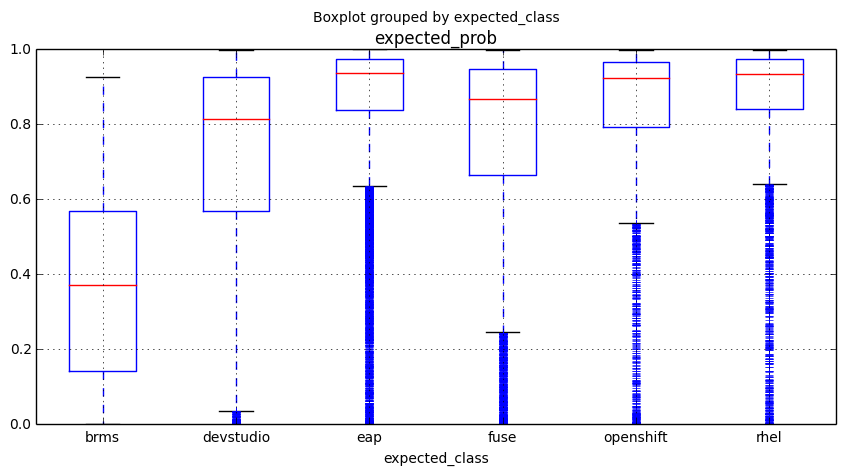

In [17]:
# boxplot visualization of the scores of documents against its own category (biggest 6 classes)
# the higher the better
# we see that it goes much better for bigger categories

# boxplot: 50% of data in box, 90% in dashed intervals
%matplotlib inline
import matplotlib.pyplot as plt

join_label_size = labels_size
join_label_size["expected_class"] = join_label_size["label"]

biggest_cats_df.boxplot("expected_prob", by="expected_class", figsize=(10,5))

In [18]:
# incorrect classification characteristics
wrong_docs_ids = pd.Series(logits[logits["expected_class"] != logits["actual_class"]].index)

wrong_docs_wordlist = wrong_docs_ids.apply(lambda doc_id: d2v_wrapper.get_doc_content(int(doc_id), word_split=True))
wrong_docs_len = wrong_docs_wordlist.apply(lambda doc: len(doc))
wrong_docs_len.describe()

count    5623.000000
mean      124.266584
std       361.569348
min        10.000000
25%        18.000000
50%        32.000000
75%        73.000000
max      7889.000000
Name: doc_id, dtype: float64

In [19]:
# correct classification characteristics
all_indices = pd.Series(np.arange(len(doc_vectors)))
correct_docs =  all_indices[~all_indices.isin(wrong_docs_ids)]
# data need to be indexed incrementally for later plotting
correct_docs.index=np.arange(len(correct_docs))
correct_docs_wordlist = correct_docs.apply(lambda doc_id: d2v_wrapper.get_doc_content(doc_id, word_split=True))
correct_docs_len = correct_docs_wordlist.apply(lambda doc: len(doc))

correct_docs_len.describe()

count    37855.000000
mean       139.294519
std        634.315085
min         10.000000
25%         26.000000
50%         41.000000
75%        104.000000
max      79212.000000
dtype: float64

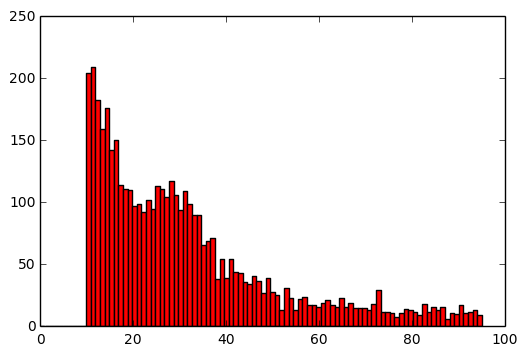

In [20]:
# missclassified docs length distribution
bordering_q = 0.8
bordering_q_value = int(wrong_docs_len.quantile(q=bordering_q))
plt.hist(wrong_docs_len, bins=bordering_q_value+1, range=(0, bordering_q_value), color="r")
plt.show()

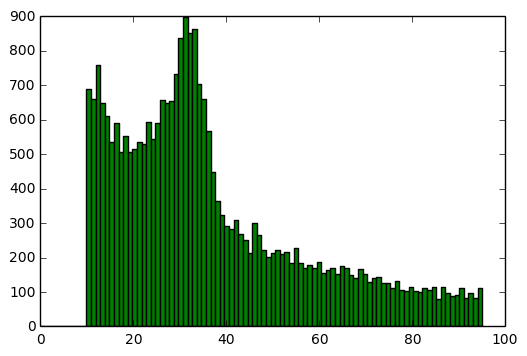

In [21]:
# correctly classified length distribution
plt.hist(correct_docs_len, bins=bordering_q_value+1, range=(0, bordering_q_value), color="g")
plt.show()

<Container object of 95 artists>

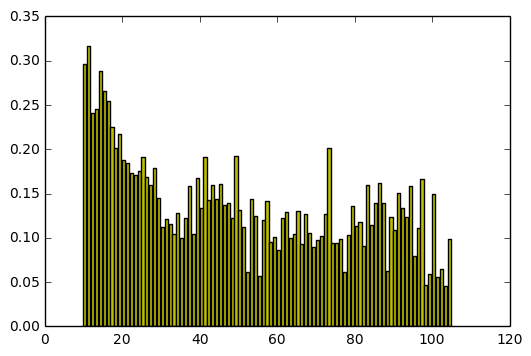

In [22]:
# distribution of incorrectly/correctly classified ratio by docs length
doc_len_error = (wrong_docs_len.value_counts() / correct_docs_len.value_counts())
ploted_doc_len_error = doc_len_error[:bordering_q_value]

plt.bar(ploted_doc_len_error.index, ploted_doc_len_error, color="y")

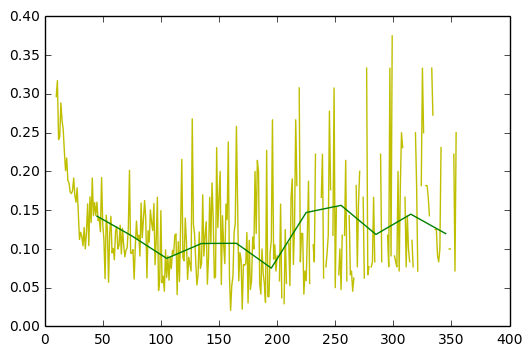

In [23]:
error_plot_border = 350
error_ploted = doc_len_error[:error_plot_border]
plt.plot(error_ploted.index, error_ploted, color="y")

mean_range = 30
mean_plot_ids = range(mean_range, error_plot_border+mean_range, mean_range)
mean_plot_vals = map(lambda mean_id: error_ploted.iloc[mean_id-5-mean_range: mean_id+5-mean_range].mean(), mean_plot_ids)
mean_plot = pd.Series(mean_plot_vals)
mean_plot.index = np.array(mean_plot_ids)-mean_range/2
plt.plot(mean_plot.index , mean_plot, color="g")

In [24]:
# above: rolling/moving average

In [25]:
# docs get associated with its content
logits["content_len"] = pd.Series(logits.index).apply(lambda doc_id: 
                                                len(d2v_wrapper.get_doc_content(int(doc_id), word_split=True))).values
logits["content"] = pd.Series(logits.index).apply(lambda doc_id: 
                                                d2v_wrapper.get_doc_content(int(doc_id), word_split=False)).values

In [26]:
# correctly classified docs with its content
logits[logits["actual_class"] != logits["expected_class"]][:30]

,actual_class,actual_prob,expected_class,expected_prob,content_len,content
doc_id,,,,,,
2437,openshift,0.662957,eap,0.245836,112,cluster node failing reconnect cluster followi...
39766,openshift,0.725577,rhel,0.002447,18,provides way trim indices elasticsearch based ...
33319,rhel,0.853692,cdk,0.069635,164,overview support policies red hat development ...
21776,openshift,0.642215,fuse,0.023234,31,install cartridges try create application even...
33346,rhel,0.737511,cdk,0.147759,85,want best experience getting questions answere...
22,rhel,0.474449,amq,0.202228,39,red hat openstack platform package listing red...
333,fuse,0.551535,amq,0.438813,472,restarting jboss fuse following messages kept ...
442,eap,0.562544,amq,0.403380,17,looking way stop broker messages received want...
39881,rhel,0.579341,softwarecollections,0.000818,268,hello welcome we re glad you re forum develope...


In [27]:
# misclassified docs with its content 
content_array = logits[logits["actual_class"] != logits["expected_class"]].iloc[:10]["content"].values
content_index = logits[logits["actual_class"] != logits["expected_class"]].iloc[:10].index.values
content_both = ["%s: %s" % (content_index[x], content_array[x]) for x in range(len(content_index))]
print reduce(lambda x, y: "%s\n\n%s" % (x, y), content_both)
# print d2v_wrapper.get_doc_content(doc_id, word_split=False)

2437: cluster node failing reconnect cluster following error error org jgroups jchannel closerthread failure reconnecting channel retrying org jgroups channelexception connect failed org jgroups jchannel connect jchannel java org jgroups jchannel closerthread run jchannel java caused java lang securityexception member ipaddr port group join request rejected org jgroups protocols pbcast clientgmsimpl join clientgmsimpl java org jgroups protocols pbcast clientgmsimpl join clientgmsimpl java org jgroups protocols pbcast gms gms java org jgroups protocols java org jgroups protocols frag frag java org jgroups protocols pbcast state transfer state transfer java org jgroups protocols pbcast flush flush java org jgroups stack protocolstack protocolstack java org jgroups jchannel downcall jchannel java org jgroups jchannel connect jchannel java.

39766: provides way trim indices elasticsearch based age openshift project namespace example delete indices project test dev older weeks.

33319: over

In [28]:
act_cdk = logits[logits["actual_class"] == "cdk"]
act_cdk[act_cdk["expected_class"] == "cdk"]

,actual_class,actual_prob,expected_class,expected_prob,content_len,content
doc_id,,,,,,
33341,cdk,0.383960,cdk,0.383960,23,vmware version vagrant box red hat enterprise ...
33333,cdk,0.560805,cdk,0.560805,78,attempting kick openshift tires cdk work natur...
33303,cdk,0.623669,cdk,0.623669,37,red hat container development kit cdk set tool...
33298,cdk,0.441221,cdk,0.441221,35,prepare mac development running container deve...
33324,cdk,0.454737,cdk,0.454737,81,red hat container development kit platform dev...
33322,cdk,0.733742,cdk,0.733742,73,red hat container development kit platform dev...
33304,cdk,0.518417,cdk,0.518417,37,prepare microsoft windows development run cont...
33325,cdk,0.514564,cdk,0.514564,64,red hat container development kit platform dev...


In [29]:
content_array = logits[logits["actual_class"] == "cdk"]["content"].values
content_index = logits[logits["actual_class"] == "cdk"].iloc[:10].index.values
content_both = ["%s: %s" % (content_index[x], content_array[x]) for x in range(len(content_index))]
print reduce(lambda x, y: "%s\n\n%s" % (x, y), content_both)

40342: red hat container development kit platform developing containerized applications set tools enables developers quickly easily set environment developing testing containerized applications red hat enterprise linux platform container development kit provides number bug fixes improvements new features including support connections http https proxy unified vagrantfiles virtualization providers hyperv virtualbox libvirt directory synchronization host container development environment sshfs installation client binaries openshift kubernetes docker host vagrant service manager plugin detailed information changes release red hat container development kit release notes linked references section.

37631: overview support policies red hat container development kit cdk document includes obtain cdk support policy developer tool obtaining cdk cdk offered red hat developer program register red hat developer program download cdk developers redhat com support cdk red hat subscriptions offered red 